In [232]:
from langchain_openai import ChatOpenAI
import json
import re
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from trino import dbapi
from trino.exceptions import TrinoUserError
from trino.exceptions import TrinoExternalError
import pandas as pd
import matplotlib.pyplot as plt

In [233]:
SYSTEM_PROMPT = """
Ты аналитический модуль внутри автоматизированного пайплайна анализа данных.
Твоя задача — строго и последовательно выполнять аналитические функции,
в зависимости от этапа. Твоя основная задача строить аналитику для бизнеса.

Модель поведения:
- Уточняй данные на естественном языке;
- Ты являешься аналитическим помошником для менеджмента.

Не выходи за рамки ответственности текущего узла.

Контекст среды:
- Источник данных — SQL через Trino,
- Схема базы данных подаётся явно,
- Визуализация выполняется через matplotlib.

Правила:
- При уточнении данных, учитывай что ты разговариваешь с бизнесом: не используй технические тармины, название столбцов, таблиц, схем и sql-термины;
- Перед написание SQL-запроса подумай, как можно сделать его максимально точным и подробным;
- Используй только таблицы/поля полученные их схемы;
- Не придумывай данные, только фичи к данным, если считаешь нужным;
- Не делай бизнес-выводов без запроса и данных;
- При построение SQL-запроса, помни о будущей визуализации;
- Возвращай только структурированный результат согласно контракту узла;
- При написании запроса к названию таблицы добавляй iceberg.gold. => iceberg.gold.table_name.
""" 

In [234]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    api_key="sk-pN7mbpwi3acKv4tu4iG8Uw",
    base_url="https://api.artemox.com/v1",  # или свой прокси / gateway
    model="gpt-5.1",
    temperature=0.1,
    max_tokens = 1000
)


In [235]:
class AgentState(TypedDict):
    user_input: str
    merged_input: str | None

    schema: dict | None 

    intent: str | None  # например: "analysis_request"
    clarification_required: bool | None
    questions: list[str] | None

    sql_query: str | None
    query_result: object | None
    analytics: str | None
    viz_code: str | None
    sql_error: str | None
    sql_fix_attempts: int


In [236]:
def schema_to_text(schema: dict | None) -> str:
    if not schema:
        return "Схема данных недоступна."

    lines = []
    for table, columns in schema.get("tables", {}).items():
        lines.append(f"Таблица {table}:")
        for col, meta in columns.items():
            col_type = meta.get("type")
            comment = meta.get("comment")
            if comment:
                lines.append(f"- {col} ({col_type}): {comment}")
            else:
                lines.append(f"- {col} ({col_type})")
        lines.append("")  # пустая строка между таблицами

    return "\n".join(lines)

def safe_json_loads(text: str) -> dict:
    """
    Безопасно извлекает JSON-объект из ответа LLM.
    Если JSON не найден — выбрасывает ValueError с понятным сообщением.
    """
    if not text or not text.strip():
        raise ValueError("LLM returned empty response")

    # Ищем первый JSON-объект вида {...}
    match = re.search(r"\{[\s\S]*\}", text)
    if not match:
        raise ValueError(f"No JSON found in LLM response:\n{text}")

    try:
        return json.loads(match.group())
    except json.JSONDecodeError as e:
        raise ValueError(
            f"Invalid JSON in LLM response:\n{match.group()}"
        ) from e



In [237]:
import json

from trino import dbapi

def schema_introspection_node(state: AgentState) -> dict:
    print(">>> ENTERED")

    conn = dbapi.connect(
        host="localhost",
        port=8081,
        user="trino_user",
        catalog="iceberg",
        schema="gold",
    )

    cursor = conn.cursor()

    # 1️⃣ список таблиц
    cursor.execute("SHOW TABLES FROM iceberg.gold")
    tables = [row[0] for row in cursor.fetchall()]

    schema = {
        "layer": "gold",
        "catalog": "iceberg",
        "tables": {}
    }

    # 2️⃣ DESCRIBE + comments
    for table in tables:
        cursor.execute(f"DESCRIBE iceberg.gold.{table}")
        rows = cursor.fetchall()

        columns = {}

        for row in rows:
            column_name = row[0]
            data_type = row[1]
            comment = row[3] if len(row) > 3 else None

            # отсекаем служебные строки
            if not column_name or column_name.startswith("#"):
                continue

            columns[column_name] = {
                "type": data_type,
                "comment": comment
            }

        schema["tables"][table] = columns

    cursor.close()
    conn.close()


    return {
        "schema": schema
    }


#Узел получения запроса и данных
def intent_node(state: AgentState) -> dict:
    text = state.get("merged_input") or state["user_input"]

    schema = state.get("schema")

    schema_text = schema_to_text(schema)

    prompt = f"""
STAGE: INTENT
Доступные данные:
{schema_text}

USER_QUERY:
{text}

Проверь, хватает ли данных для генерации SQL.

Минимально требуется:
- Аналитическая цель
- Бизнес-метрики
- Аналитическая логика запроса

Верни JSON строго в формате:
{{
  "clarification_required": boolean,
  "questions": [string]
}}
"""

    response = llm.invoke([
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": prompt},
    ])

    parsed = json.loads(response.content)

    print("\n=== INTENT LLM ===")
    print(response.content)

    return {
        "clarification_required": parsed["clarification_required"],
        "questions": parsed.get("questions"),
    }

#Узел маршрута, по условию хватает ли данных для запроса
def route_after_intent(state: AgentState) -> str:
    """
    Маршрутизация (НЕ LLM):
    - если нужны уточнения -> clarification_node
    - иначе -> sql_exec_node
    """
    if state.get("clarification_required"):
        return "clarification_node"
    return "sql_generation_node"

#Цикл повтора
def clarification_node(state: AgentState) -> dict:
    """
    Одна нода для уточнения:
    - показывает вопросы
    - принимает один ввод пользователя
    - добавляет его к merged_input
    """
    print("\n❓ Не хватает данных. Уточни, пожалуйста:")

    for q in (state.get("questions") or []):
        print(f"- {q}")

    clarification = input("\nВведите уточнение одним сообщением:\n> ").strip()

    base = state.get("merged_input") or state["user_input"]
    merged = f"{base}\n\nУТОЧНЕНИЕ:\n{clarification}"

    return {
        "merged_input": merged
    }

# def sql_planning_node(state: AgentState) -> dict:
#     """
#     Пока заглушка.
#     Тут ты дальше сделаешь генерацию SQL под Trino на основе merged_input + схемы.
#     """
#     final_context = state.get("merged_input") or state["user_input"]

#     print("\n✅ Данных достаточно. Переходим к SQL_PLANNING.")
#     print("\n=== FINAL CONTEXT ===")
#     print(final_context)

#     # заглушка
#     return {}

#Генерация sql
def sql_generation_node(state: AgentState) -> dict:
    """
    Генерирует SQL-запрос (Trino SQL) на основе финального контекста.
    """
    final_context = state.get("merged_input") or state["user_input"]
    schema = state.get("schema")

    schema_text = schema_to_text(schema)
    print("\n✅ Данных достаточно. Переходим к SQL_PLANNING.")
    print("\n=== FINAL CONTEXT ===")
    print(final_context)

    final_text = state.get("merged_input") or state["user_input"]

    prompt = f"""
STAGE: SQL_GENERATION

Доступные данные:
{schema_text}

USER_REQUEST:
{final_text}

Требования:
- Сгенерируй SQL-запрос для Trino
- Округляй все числа до двух точек после запятой
- Используй только те таблицы и поля, которые указаны пользователем
- Если период указан текстом (например, "весь 2021 год") — корректно преобразуй в фильтр по датам
- Если метрика указана — используй её
- Если группировка указана — добавь GROUP BY
- Если чего-то не хватает, сделай разумное допущение, но НЕ задавай вопросов

Верни результат СТРОГО в JSON формате:
{{
  "sql_query": "string"
}}
"""

    response = llm.invoke([
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": prompt},
    ])

    print("\n=== SQL LLM ===")
    print(response.content)

    parsed = safe_json_loads(response.content)

    return {
        "sql_query": parsed["sql_query"]
    }

from trino import dbapi


def sql_exec_node(state: AgentState) -> dict:
    sql = state.get("sql_query")
    if not sql:
        return {
            "sql_error": "sql_exec_node: sql_query is empty"
        }

    print("\n🚀 EXECUTING SQL IN TRINO")
    print(sql)

    try:
        conn = dbapi.connect(
            host="localhost",
            port=8081,
            user="trino_user",
            catalog="iceberg",
            schema="gold",
        )

        cursor = conn.cursor()
        cursor.execute(sql)

        rows = cursor.fetchall()
        columns = [col[0] for col in cursor.description]

        cursor.close()
        conn.close()

        return {
            "query_result": {
                "columns": columns,
                "rows": rows
            },
            "sql_error": None   # 🔥 ВАЖНО: явно сбрасываем ошибку
        }

    except TrinoUserError as e:
        # ❗ SQL ошибка (синтаксис, поля, GROUP BY и т.д.)
        error_text = f"TrinoUserError: {e}"

        print("\n❌ TRINO USER ERROR")
        print(error_text)

        return {
            "sql_error": error_text,
            "query_result": None
        }

    except TrinoExternalError as e:
        # ❗ Ошибка движка / кластера
        error_text = f"TrinoExternalError: {e}"

        print("\n❌ TRINO EXTERNAL ERROR")
        print(error_text)

        return {
            "sql_error": error_text,
            "query_result": None
        }

    except Exception as e:
        # ❗ Любая другая ошибка (network, Python, etc.)
        error_text = f"Unexpected error in sql_exec_node: {e}"

        print("\n❌ UNEXPECTED ERROR")
        print(error_text)

        return {
            "sql_error": error_text,
            "query_result": None
        }

def route_after_sql_exec(state: AgentState) -> str:
    sql_error = state.get("sql_error")
    attempts = state.get("sql_fix_attempts", 0)

    print("DEBUG ROUTER")
    print("sql_error repr:", repr(state.get("sql_error")))
    print("attempts:", state.get("sql_fix_attempts"))
    # ❌ Есть реальная ошибка
    if sql_error is not None:
        if attempts >= 3:
            print("\n⛔ SQL fix attempts limit reached")
            return END
        return "sql_error_fix_node"

    # ✅ Ошибки нет → идём дальше
    return "viz_planning_node"


def sql_error_fix_node(state: AgentState) -> dict:
    """
    Исправляет SQL-запрос на основе ошибки Trino.
    Максимум 3 попытки.
    """

    sql_query = state.get("sql_query")
    sql_error = state.get("sql_error")
    attempts = state.get("sql_fix_attempts", 0)

    if not sql_query or not sql_error:
        raise ValueError("sql_error_fix_node: missing sql_query or sql_error")


    user_text = state.get("merged_input") or state["user_input"]
    schema = state.get("schema")
    schema_text = schema_to_text(schema)

    prompt = f"""
STAGE: SQL_ERROR_FIX

ТРЕБОВАНИЯ ПОЛЬЗОВАТЕЛЯ:
{user_text}

СХЕМА ДАННЫХ:
{schema_text}

ОРИГИНАЛЬНЫЙ SQL:
{sql_query}

ОШИБКА TRINO:
{sql_error}


ЗАДАЧА:
- Проанализируй ошибку Trino
- Исправь SQL-запрос
- НЕ меняй бизнес-логику запроса
- Верни корректный SQL для Trino

Верни результат СТРОГО в JSON формате:
{{
  "sql_query": "string"
}}
"""

    response = llm.invoke([
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": prompt},
    ])

    print("\n=== SQL ERROR FIX LLM RAW ===")
    print(response.content)

    parsed = safe_json_loads(response.content)

    return {
        "sql_query": parsed["sql_query"],
        "sql_error": None,                 # сбрасываем ошибку
        "sql_fix_attempts": attempts + 1,  # увеличиваем счётчик
    }



def viz_planning_node(state: AgentState) -> dict:
    qr = state.get("query_result")

    if not qr:
        raise ValueError("viz_planning_node: query_result is empty")

    columns = qr["columns"]
    rows = qr["rows"][:10]  # показываем LLM только пример

    prompt = f"""
STAGE: VISUALIZATION_PLANNING

ДАННЫЕ:
Колонки: {columns}
Пример строк:
{rows}

Твоя задача:
1. Определи наиболее подходящий тип графика
2. Напиши Python-код для matplotlib
3. Сформулируй краткий аналитический вывод по данным

Ограничения:
- код будет исполняться в окружении, где уже есть:
  - pandas as pd
  - matplotlib.pyplot as plt
  - DataFrame df (создан заранее)
- НЕ импортируй os, sys, subprocess
- НЕ читай и не пиши файлы
- используй ТОЛЬКО df

Верни результат СТРОГО в JSON формате:
{{
  "viz_code": "string",
  "analytics": "string"
}}
"""

    response = llm.invoke([
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": prompt},
    ])

    print("\n=== VIZ LLM RAW ===")
    print(response.content)

    parsed = safe_json_loads(response.content)

    return {
        "viz_code": parsed["viz_code"],
        "analytics": parsed["analytics"],
    }

def viz_exec_node(state: AgentState) -> dict:

    qr = state.get("query_result")
    code = state.get("viz_code")

    if not qr or not code:
        raise ValueError("viz_exec_node: missing query_result or viz_code")

    # создаём DataFrame
    df = pd.DataFrame(qr["rows"], columns=qr["columns"])

    print("\n=== EXECUTING VIZ CODE ===")
    print(code)

    # безопасное окружение выполнения
    exec_globals = {
        "pd": pd,
        "plt": plt,
        "df": df,
    }

    exec(code, exec_globals)

    plt.show()

    return {}





In [238]:
graph = StateGraph(AgentState)

graph.add_node("schema_introspection_node", schema_introspection_node)
graph.add_node("intent_node", intent_node)
graph.add_node("clarification_node", clarification_node)
graph.add_node("sql_generation_node", sql_generation_node)
graph.add_node("sql_exec_node", sql_exec_node)
graph.add_node("sql_error_fix_node", sql_error_fix_node)
graph.add_node("viz_planning_node", viz_planning_node)
graph.add_node("viz_exec_node", viz_exec_node)

# строим последовательность выполнения
graph.add_edge(START, "schema_introspection_node")
graph.add_edge("schema_introspection_node","intent_node")
graph.add_conditional_edges(
    "intent_node",
    route_after_intent,
    {
        "clarification_node": "clarification_node",
        "sql_generation_node": "sql_generation_node",
    }
)
# цикл уточнений
graph.add_edge("clarification_node", "intent_node")
graph.add_edge("sql_generation_node", "sql_exec_node")
graph.add_conditional_edges(
    "sql_exec_node", 
    route_after_sql_exec,
    {
        "sql_error_fix_node": "sql_error_fix_node",
        "viz_planning_node": "viz_planning_node",
    }
    
)
graph.add_edge("sql_error_fix_node", "sql_exec_node")
graph.add_edge("viz_planning_node", "viz_exec_node")
graph.add_edge("viz_exec_node", END)



compiled = graph.compile()

USER INPUT: Какие жанры перегреты (много игр, низкие метрики)?
>>> ENTERED

=== INTENT LLM ===
{
  "clarification_required": true,
  "questions": [
    "Уточните, какие именно показатели для вас приоритетны, когда вы говорите «низкие метрики»: интересуют в первую очередь отзывы игроков (доля рекомендаций), вовлечённость (часы игры) или стоимость игр?",
    "Как вы хотите трактовать «много игр в жанре»: ориентируемся на абсолютное количество игр или, например, на верхний процент жанров по числу игр?",
    "Что для вас считается «низкими» метриками: ниже среднего по рынку, ниже определённого порога (например, 70% рекомендаций, менее 5 часов игры) или важно сравнение внутри жанров между собой?",
    "Нужно ли в анализе учитывать только агрегированные данные по жанрам (сводная таблица по жанрам), или вы хотите опираться ещё и на разрез по отдельным играм, чтобы точнее оценить перегрев жанров?"
  ]
}

❓ Не хватает данных. Уточни, пожалуйста:
- Уточните, какие именно показатели для вас приор

<string>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


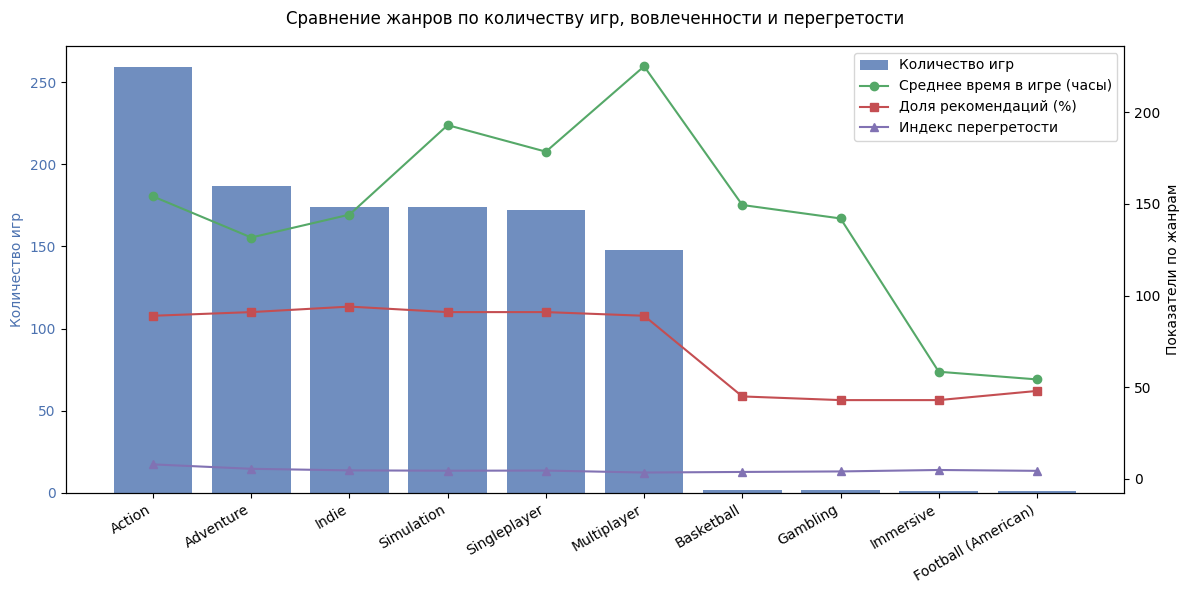


=== FINAL STATE ===
user_input: Какие жанры перегреты (много игр, низкие метрики)?
merged_input: Какие жанры перегреты (много игр, низкие метрики)?

УТОЧНЕНИЕ:
пререгретый жанр - тот, где много игр, но низкая вовлеченность (низкое время в игре и низкие рекоммендации). жанры необходимо сравнивать между собой по комабинации факторов и вывести топ-10 перегретых. учитываем все жанры.
schema: {'layer': 'gold', 'catalog': 'iceberg', 'tables': {'dm_genre_performance': {'genre': {'type': 'varchar', 'comment': 'Жанр видеоигр'}, 'games_cnt': {'type': 'bigint', 'comment': 'Количество игр в данном жанре'}, 'avg_price': {'type': 'double', 'comment': 'Средняя стоимость игр в жанре'}, 'players_total_cnt': {'type': 'bigint', 'comment': 'Общее количество игроков, оставивших отзывы по жанру'}, 'recommendation_rate': {'type': 'double', 'comment': 'Средняя доля положительных рекомендаций по жанру'}, 'avg_hours_played': {'type': 'double', 'comment': 'Среднее количество часов, проведённых в играх жанра'}},

In [ ]:
if __name__ == "__main__":
    user_query = input("Введите запрос:")

    initial_state: AgentState = {
        "user_input": user_query,
        "schema": None,
        "merged_input": None,
        
        "clarification_required": None,
        "questions": None,
        
        "sql_query": None,

        "query_result": None,
        "analytics": None,
        "viz_code": None,
        "sql_error": None,
        "sql_fix_attempts": 0,
        
    }

    print("USER INPUT:", initial_state["user_input"])

    result_state = compiled.invoke(initial_state)
    
    #print("PARSED INTENT:", result_state["intent"])

    print("\n=== FINAL STATE ===")
    for k, v in result_state.items():
        print(f"{k}: {v}")

In [240]:
print(result_["schema"])

NameError: name 'result_' is not defined

In [241]:
print(result_state["analytics"])

В выборке выделяются несколько жанров с существенно большим количеством игр, при этом по ним же наблюдается более высокое среднее время в игре и высокая доля рекомендаций. Отдельные жанры с небольшим числом игр демонстрируют сопоставимое или даже выше среднее время, но при этом более низкий уровень рекомендаций и повышенный индекс перегретости, что может говорить о завышенных ожиданиях или неустойчивом интересе игроков к таким нишевым направлениям.
